<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/MLT-x-fastai/blob/master/mini-lessons/fastai-vision-data-examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai import *
from fastai.vision import *

## Object Detection 
Next, we'll take a look at an object detection. `fastai` provides a `ObjectItemList` class for creating a `databunch` for this task. However, similar to the previous dataset this one also has some caveats that we will explore. 


### X-Ray Images
`fastai` uses `PIL` to open images from files and then turns them into `pytorch` tensors. X-Ray images are stored as [dicom](https://pydicom.github.io/pydicom/stable/getting_started.html) files and `PIL` cannot open them. So we will try to overwrite the `open_image` (for starters) function in `fastai` and create `databunch` for an object detection task. The task here will be detecting and localizing pneumonia from x-rays.
The data can be downloaded from the kaggle challenge [here](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data).

### Downloading Kaggle datasets into Colab
First you want to get your kaggle api credentials from your kaggle account then install the kaggle api 
```
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload() #upload the kaggle.json file that you got from your account
!cp kaggle.json ~/.kaggle/
```
Once you have this setup you can download datasets using the api:
`!kaggle competitions download -c rsna-pneumonia-detection-challenge`

In [0]:
#!echo '{"username":"username","key":"key"}' > ~/.kaggle/kaggle.json

In [0]:
#!kaggle competitions download -c rsna-pneumonia-detection-challenge

In [0]:
#!mkdir stage_2_train_images
#!unzip stage_2_train_images.zip -d stage_2_train_images
#!unzip stage_2_train_labels.csv.zip
#!unzip stage_2_detailed_class_info.csv.zip

In [4]:
path = Path('.')
path.ls() 

[PosixPath('.config'),
 PosixPath('stage_2_sample_submission.csv'),
 PosixPath('stage_2_detailed_class_info.csv.zip'),
 PosixPath('stage_2_train_images.zip'),
 PosixPath('stage_2_train_labels.csv.zip'),
 PosixPath('stage_2_detailed_class_info.csv'),
 PosixPath('data'),
 PosixPath('stage_2_train_images'),
 PosixPath('stage_2_test_images.zip'),
 PosixPath('GCP%20Credits%20Request%20Link%20-%20RSNA.txt'),
 PosixPath('stage_2_train_labels.csv'),
 PosixPath('sample_data')]

In [0]:
TRAIN_IMG = path/'stage_2_train_images'
TRAIN_LABEL = path/'stage_2_train_labels.csv'

In [0]:
#!pip install pydicom
import pydicom
from matplotlib import cm
from matplotlib import pyplot as plt

In [7]:
df = pd.read_csv(TRAIN_LABEL)
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
def show_dcm_info(file):
    ##read a dicom file and print some info
    print("Filename.........:", path/file.PatientID)
    print("Storage type.....:", file.SOPClassUID)
    print()

    pat_name = file.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", file.PatientID)
    print("Patient's Age.......:", file.PatientAge)
    print("Patient's Sex.......:", file.PatientSex)
    print("Modality............:", file.Modality)
    print("Body Part Examined..:", file.BodyPartExamined)
    print("View Position.......:", file.ViewPosition)
    
    if 'PixelData' in file:
        rows = int(file.Rows)
        cols = int(file.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(file.PixelData)))
        if 'PixelSpacing' in file:
            print("Pixel spacing....:", file.PixelSpacing)

In [0]:
def show_img(file, figsize=(10,10)):
    #plot the image using matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(file.pixel_array, cmap=plt.cm.bone)
    plt.show()


Filename.........: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, 
Patient id..........: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Patient's Age.......: 51
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 142006 bytes
Pixel spacing....: ['0.14300000000000002', '0.14300000000000002']


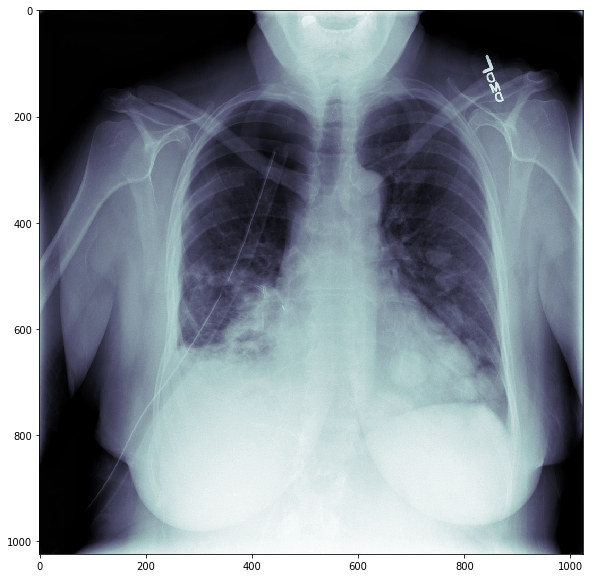

In [10]:
# Lets take a look at one x-ray
file_path = str(TRAIN_IMG/(df.iloc[0]['patientId']+'.dcm'))
file = pydicom.dcmread(file_path)
show_dcm_info(file)
show_img(file)

In [0]:
tfms = get_transforms()

In [0]:
open_image??

In [0]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        #custom open
        dicom_arr = pydicom.dcmread(file_path).pixel_array
        x = PIL.Image.fromarray(dicom_arr).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

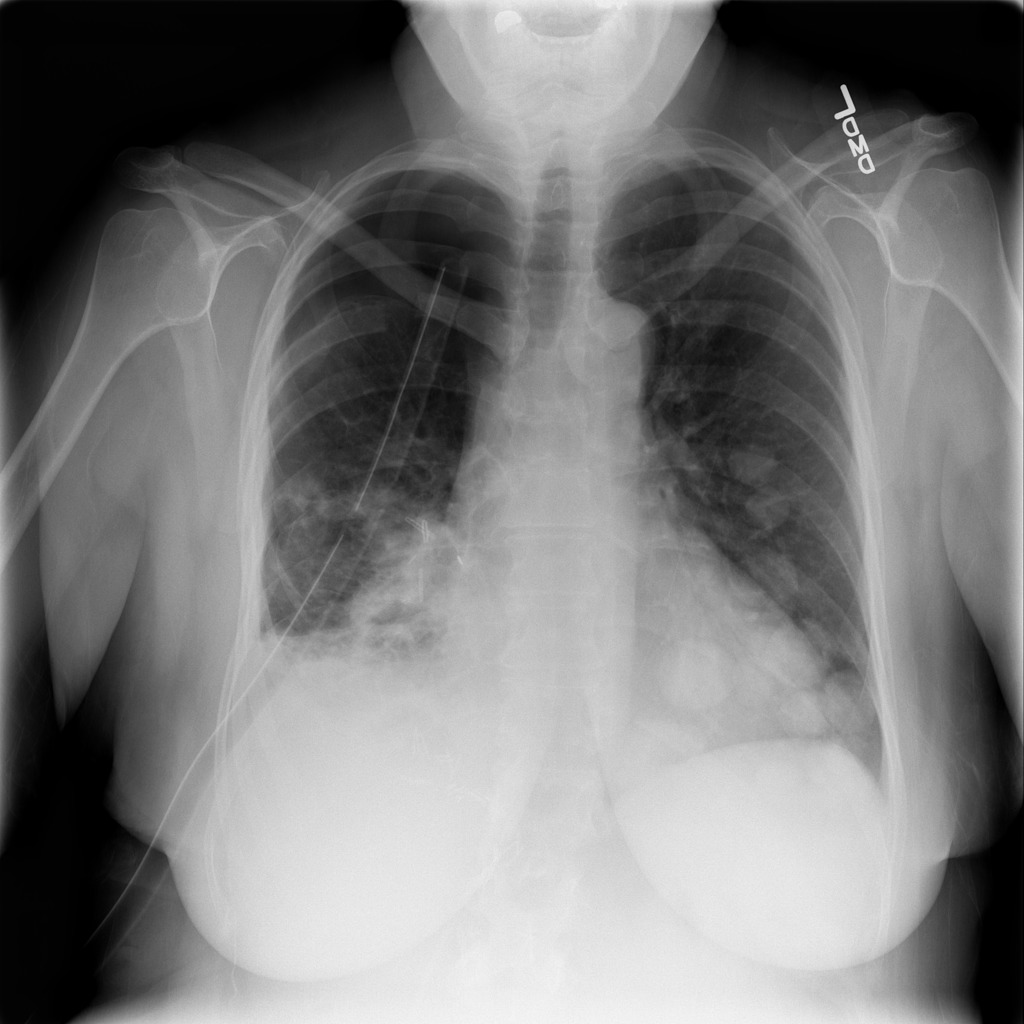

In [94]:
open_image(file_path)

In [0]:
ImageList??

In [0]:
class DicomItemList(ImageList):
    ## overwrite the open func in ImageList
    def open(self, fn): return open_image(fn)

In [0]:
data = (DicomItemList.from_df(df.head(100),TRAIN_IMG,cols='patientId',suffix='.dcm')
                 .split_by_rand_pct()
                 .label_from_df('Target')
                 .transform(tfms)
                 .databunch(bs=6))

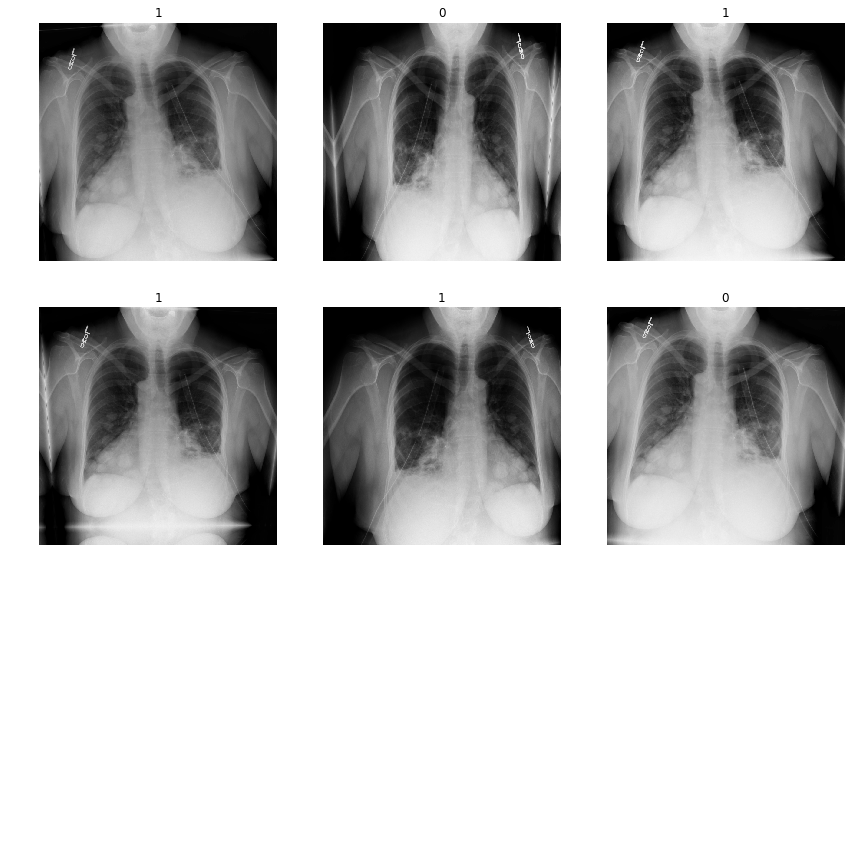

In [15]:
data.show_batch()

Now that we've learned how to open these images, next step would be to use bounding boxes to localize the areas with pneumonia.

In [0]:
ObjectItemList??

In [0]:
class DicomItemList(ObjectItemList):
    def open(self, fn): return open_image(fn)

In [18]:
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [19]:
detailed_df = pd.read_csv(path/'stage_2_detailed_class_info.csv')
detailed_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


We have two different `csv` files to look through. The first one contains the bounding boxes and the second one contains the class values. `fastai` expects the filename of the image as the `x` value and `bboxes,class` tuple as the `y` value. `bboxes,class` are lists of bounding boxes (`[[x1,y1,width1,height1],[x2,y2,width2,height2]...]`) and their corresponding class labels (`[class1,class2..]`)

In [0]:
def get_bbox_df(df, detailed_df):
    #get all bboxes and classes from dataframe
    df['duplicate'] = df.duplicated(['patientId'], keep=False)
    class_df = df.merge(detailed_df, on="patientId")
    mb_df = class_df.filter(['patientId', 'x','y','width','height'])
    
    #replace na values with the the entire image as the bbox
    na_values = {'x': 0, 'y': 0, 'width': 1024, 'height': 1024}
    mb_df = mb_df.fillna(na_values)
    
    #combine bboxes into a single string 'x1 y1 width1 height1 x2 y2 width2 height2 ...'
    mb_df['combined']=mb_df['x'].astype(str)+' '+mb_df['y'].astype(str)+' '+mb_df['width'].astype(str)+' '+mb_df['height'].astype(str)
    mb_df.drop_duplicates(subset=['patientId', 'combined'], inplace=True) 
    mb_df = mb_df.groupby('patientId').agg(lambda x: ' '.join((x)))
    
    #add target and class column to the dataframe
    targ_df = class_df.filter(['patientId','Target','class'])
    targ_df.drop_duplicates(subset=['patientId', 'Target'],inplace=True)
    mb_df = mb_df.merge(targ_df, on='patientId')
    
    #set partientId as index
    #mb_df.set_index('patientId',inplace=True)
    
    return mb_df

In [21]:
mb_df = get_bbox_df(df,detailed_df)
mb_df.head()

,patientId,combined,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0 0.0 1024.0 1024.0,0,No Lung Opacity / Not Normal
1,000924cf-0f8d-42bd-9158-1af53881a557,0.0 0.0 1024.0 1024.0,0,Normal
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0 318.0 170.0 478.0 660.0 375.0 146.0 402.0,1,Lung Opacity
3,000fe35a-2649-43d4-b027-e67796d412e0,570.0 282.0 269.0 409.0 83.0 227.0 296.0 438.0,1,Lung Opacity
4,001031d9-f904-4a23-b3e5-2c088acd19c6,66.0 160.0 373.0 608.0 552.0 164.0 376.0 676.0,1,Lung Opacity


In [0]:
row = mb_df[mb_df['patientId'] == '0004cfab-14fd-4e49-80ba-63a80b6bddd6'].values

In [23]:
row[0][1]

'0.0 0.0 1024.0 1024.0'

In [0]:
def get_bb_label(fn):
    #get labels from the dataframe in the format bboxes-->list,targets-->list
    fn = fn.replace(str(TRAIN_IMG)+'/','').replace('.dcm','')
    row = mb_df[mb_df['patientId'] == fn].values[0]
    bboxes = row[1].split(' ')
    bboxes = [float(o) for o in bboxes]
    bboxes = [bboxes[i:i+4] for i in range(0,len(bboxes),4)]
    targets = row[-1]
    return bboxes,[targets]*len(bboxes)
    #return ','.join(str(o) for o in row[1:])

In [0]:
data = (DicomItemList.from_df(mb_df,TRAIN_IMG,cols='patientId',suffix='.dcm')
                    .split_by_rand_pct()
                    .label_from_func(get_bb_label)
                    .transform(tfms)
                    .databunch(bs=6,collate_fn=bb_pad_collate))

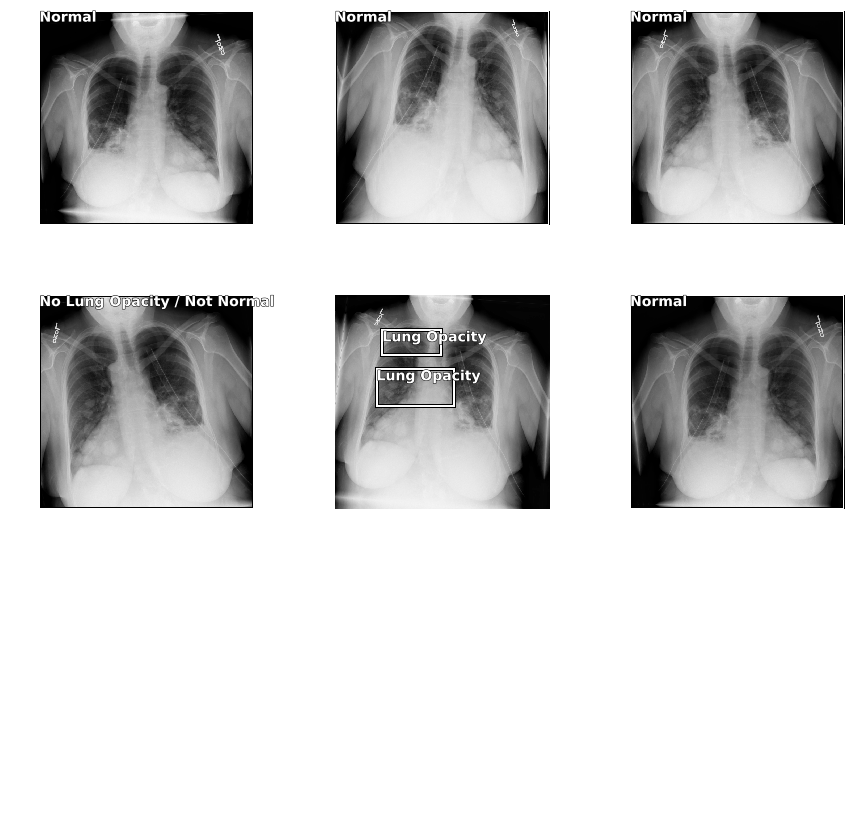

In [26]:
data.show_batch()

`fastai` doesn't yet provide an out-of-the-box Retina Net implementation yet. But probably it will be covered in part 2 of course-v3. Meanwhile, a few of people have come up with their own little models like in this [thread](https://forums.fast.ai/t/object-detection-in-fast-ai-v1/29266/10). We recommend you take a look at some examples and try to re-implement them in your own way.